# Calculate ICC of QAP measures from CORR data
Code to calculate the modern ICC version (using linear mixed-effects model).
A lot is borrowed from AFNI's 3dICC_REML.R. Big shout out to the AFNI folks.

In [1]:
library(lme4)
library(dplyr)
library(reshape2)
library(tidyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(boot)
library(repr)

Loading required package: Matrix

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths

The following object is masked from ‘package:Matrix’:

    expand


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:

## ICC
#' 
#' For each measure, we calculate the ICC using bootstrap to estimate confidence intervals.
#' We do this with our own code so we can ensure non-negative values amongst other things.
#' 
icc <- function(data, indices) {
  d <- data[indices,] %>% 
         melt(id.vars=c('Participant','Site',
                        'Series','Measure'),
              measure.vars=c('session_1','session_2'),
                        variable.name="Session")
  fit <- lmer(value ~ 1 + Site + (1|Participant), d)
  s_e = sigma(fit)
  s_a2 = VarCorr(fit)[[1]][1]
  return(s_a2 / (s_e^2 + s_a2))
}

## CORR anatomical QAP measures

### read and tidy the data

In [4]:
# read the data
corr_anat_qa<-read.csv("2016_05_CORR_qap_anatomical_spatial.csv")

# reduce to the columns that we are interested in
id.vars=c('Participant','Site','Session','Series')
measure.vars=c('CNR','Cortical.Contrast','EFC','FBER','FWHM','Qi1','SNR')
corr_anat_qa<-corr_anat_qa[c(id.vars,measure.vars)]

# Filter 1
# Use only the first scan from sessions 1 & 2
corr_anat_qa <-  corr_anat_qa %>% 
                  filter(Series == 'anat_1') %>% 
                   filter(Session %in% c('session_1','session_2'))
corr_anat_qa$Series <- droplevels(corr_anat_qa$Series)
corr_anat_qa$Session <- droplevels(corr_anat_qa$Session)

# Filter 2 
# remove participants that do not have two sessions of data
pts_keep <- (corr_anat_qa %>% 
             group_by(Participant) %>% 
              summarise(N=n()) %>%
               filter(N>1))$Participant
corr_anat_qa <-  corr_anat_qa %>% 
                  filter(Participant %in% pts_keep)
# corr_anat_qa$Participant <- droplevels(corr_anat_qa$Participant)

# Filter 3 
# remove Sites that have fewer than 5 pts
sites_keep <- (corr_anat_qa %>% 
                 group_by(Site,Session) %>% 
                   summarise(N=n()) %>%
                     filter(N>5))$Site

corr_anat_qa <-  corr_anat_qa %>% 
                  filter(Site %in% sites_keep)
corr_anat_qa$Site <- droplevels(corr_anat_qa$Site)

corr_anat_qa <- corr_anat_qa %>% 
                  melt(id.vars=id.vars,
                       measure.vars=measure.vars,
                       variable.name="Measure")

corr_anat_qa$Participant <- factor(corr_anat_qa$Participant)

# one last thing, remove 25296, they are an outlier on motion
corr_anat_qa <- corr_anat_qa %>% filter(Participant != 25296)

table(corr_anat_qa$Site, corr_anat_qa$Session)

         
          session_1 session_2
  BNU_1         350       350
  BNU_2         427       427
  HNU_1         210       210
  IACAS         189       189
  IBA_TRT        98        98
  IPCAS_1       210       210
  IPCAS_2       245       245
  IPCAS_8        91        91
  LMU_3         175       175
  MRN           336       336
  NYU_1         175       175
  NYU_2         434       434
  SWU_1         133       133
  SWU_3         168       168
  SWU_4        1638      1638
  UM            560       560
  UPSM_1        686       686
  Utah_1        133       133
  UWM           175       175
  XHCUMS        168       168

### calculate ICC

    n_boot=1000
    icc_dc<-data_frame()
    for (measure in unique(corr_anat_qa$Measure)){
        sdf<-corr_anat_qa %>% 
               filter(Measure == measure) %>% 
                 spread(Session, value)
        system.time(results <- boot(data=sdf, statistic=icc, R=n_boot, parallel="multicore", ncpus=20, strata=sdf$Site))
        icc_dc<-rbind(icc_dc,data_frame(Measure=rep(measure,n_boot),Iteration=seq(1,n_boot),Value=as.vector(results$t)))
    }
    write.table(icc_dc, file = "corr_anat_spat.csv")

## CORR functional QAP measures

### read and tidy the data

In [5]:
# read the data
corr_func_qa<-read.csv("2016_05_CoRR_qap_functional_spatial.csv")

# reduce to the columns that we are interested in
id.vars=c('Participant','Site','Session','Series')
measure.vars=c('EFC','FBER','FWHM','Ghost_y','SNR')
corr_func_qa<-corr_func_qa[c(id.vars,measure.vars)]

# read in the temporal measures
tdf<-read.csv("2016_05_CORR_qap_functional_temporal.csv")
tmeasure.vars=c('Fraction.of.Outliers..Mean.','GCOR','Quality..Mean.',
                'RMSD..Mean.','Std..DVARS..Mean.')
tdf<-tdf[c(id.vars,tmeasure.vars)]

# combine the datasets
corr_func_qa<-merge(corr_func_qa,tdf,by=id.vars)
measure.vars<-c(measure.vars,tmeasure.vars)

# Filter 1
# Use only the first scan from sessions 1 & 2
corr_func_qa <-  corr_func_qa %>% 
                  filter(Series == 'rest_1') %>% 
                   filter(Session %in% c('session_1','session_2'))
corr_func_qa$Series <- droplevels(corr_func_qa$Series)
corr_func_qa$Session <- droplevels(corr_func_qa$Session)

# Filter 2 
# reduce to same participants in anatomical analysis
corr_func_qa <-  corr_func_qa %>% 
                  filter(Participant %in% corr_anat_qa$Participant)
corr_func_qa$Site <- droplevels(corr_func_qa$Site)

# mult table to make a seperate row for each obs of each measure
corr_func_qa <- corr_func_qa %>% 
                  melt(id.vars=id.vars,
                       measure.vars=measure.vars,
                       variable.name="Measure")

# make sure that participant is a factor
corr_func_qa$Participant <- factor(corr_func_qa$Participant)

table(corr_func_qa$Site, corr_func_qa$Session)

         
          session_1 session_2
  BNU_1         500       500
  BNU_2         610       610
  HNU_1         300       300
  IACAS         270       270
  IBA_TRT       140       140
  IPCAS_1       300       300
  IPCAS_2       350       350
  IPCAS_8       130       130
  LMU_3         250       250
  MRN           390       420
  NYU_1         250       250
  NYU_2         620       620
  SWU_1         190       190
  SWU_3         240       240
  SWU_4        2330      2330
  UM            800       800
  UPSM_1        980       980
  Utah_1        190       190
  UWM           250       250
  XHCUMS        240       240

### Calculate ICC


    n_boot=1000
    icc_dc<-data_frame()
    for (measure in unique(corr_func_qa$Measure)){
        print(sprintf("Calculating ICC for %s", measure))
        sdf<-corr_func_qa %>% 
               filter(Measure == measure) %>% 
                 spread(Session, value)
        results <- boot(data=sdf, statistic=icc, R=n_boot, 
                        parallel="multicore", ncpus=20, strata=sdf$Site)
        icc_dc<-rbind(icc_dc,
                      data_frame(Measure=rep(measure,n_boot),
                                 Iteration=seq(1,n_boot),
                                 Value=as.vector(results$t)))
    }
    write.table(icc_dc, file = "corr_func_icc_meanfd.csv")

## Create the figures

In [86]:
# read the sMRI values
icc_df_smri<-read.table("corr_anat_spat.csv")
icc_df_smri$Datasource<-"Structural MRI"

# read the fMRI values
icc_df_fmri<-read.table("corr_func_icc_meanfd.csv")
icc_df_fmri$Datasource<-"Functional MRI"

# combine into s single dataframe
icc_df<-rbind(icc_df_smri,icc_df_fmri)

head(icc_df)

Measure,Iteration,Value,Datasource
CNR,1,0.6624920,Structural MRI
CNR,2,0.6545427,Structural MRI
CNR,3,0.6429974,Structural MRI
CNR,4,0.6359006,Structural MRI
CNR,5,0.6603972,Structural MRI
CNR,6,0.6160225,Structural MRI


In [87]:
df<-icc_df
levels(df$Measure)<-list(CNR='CNR',
                         CC='Cortical.Contrast',
                         EFC='EFC',
                         FBER='FBER',
                         FWHM='FWHM',
                         FAV='Qi1',
                         SNR='SNR',
                         GSR='Ghost_y',
                         MFO='Fraction.of.Outliers..Mean.',
                         GCOR='GCOR',
                         MQI='Quality..Mean.',
                         MRMSD='RMSD..Mean.',
                         MDVRS='Std..DVARS..Mean.')

In [88]:
g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)}
                      
options(repr.plot.width=180.0/25.4, repr.plot.height=3)
nrow=1
ncol=3
strat_var='Measure'
cols=c("#78a22f","#f58025","#ffd457","#d75920")
icc_interp=data_frame(x1=c(0,0,0,0),
                     x2=c(+Inf,+Inf,+Inf,+Inf),
                     y1=c(0.0,0.4,0.6,0.75),
                     y2=c(0.4,0.6,0.75,1.2),
                     Interp=factor(c("Poor","Fair","Good","Excellent")))


    
    mean_sdlow<-function(x) (mean(x)-sd(x))
        
    mean_sdhigh<-function(x) (mean(x)+sd(x))
    
    vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

    pval_thresh=c(0.05,0.01,0.001,0.0001)
    pval_indicators=c("*","**","***","****")
        
    datasource.vars = unique(df$Datasource)
        
    p=list()

    for (i in seq(1,length( datasource.vars)))
    {
        # get only the rows corresponding to this measure
        sdf<- df %>% filter(Datasource == datasource.vars[i])
        sdf_ranges <- sdf %>% 
                       group_by_(as.formula(sprintf('%s ~ .',strat_var))) %>% 
                         summarise(y=mean(Value),y.max=mean_sdhigh(Value),y.min=mean_sdlow(Value)) %>% 
                             ungroup
        
        val_range=quantile(sdf$value, probs = c(0.02,.98))
        val_range["2%"]=min(val_range["2%"],min(sdf_ranges$y.min))
        val_range["98%"]=max(val_range["98%"],max(sdf_ranges$y.max))
        
        x_string=sprintf("as.factor(%s)",strat_var)
        p[[i]] <- ggplot() + 
            geom_blank(data=sdf, aes_string(x=x_string, y='Value')) +  
            geom_rect(data=icc_interp, mapping=aes(xmin=x1, xmax=x2, 
                                                   ymin=y1, ymax=y2,
                                                   fill=Interp), alpha=0.25) +
            scale_fill_manual(values = cols, 
                              guide=guide_legend(title = "ICC Values",
                                                 direction = "horizontal",
                                                 title.position = "top",
                                                 title.hjust = 0.5,
                                                 title.theme = element_text(family = "ArialMT",
                                                                            face = "plain",
                                                                            size = 10,
                                                                            angle = 0,
                                                                            vjust = 0,
                                                                            hjust = 0),
                                                 label.theme = element_text(family = "ArialMT",
                                                                 face = "plain",
                                                                 size = 8, 
                                                                 angle = 0, 
                                                                 hjust = 1))) +
            geom_boxplot(data=sdf, aes_string(x=x_string, y='Value'),
                         outlier.shape = NA, width=.5, fill='white') + 
            theme_bw() +
            ggtitle(datasource.vars[[i]])+
            xlab("")+
            ylab("ICC(2,1)")+
            theme(plot.title = element_text(family = "ArialMT",
                                             face = "plain",
                                             size = 10,
                                             vjust = 0,
                                             hjust = 0.5),
                  axis.text.x = element_text(family = "ArialMT",
                                             face = "plain",
                                             size = 8, 
                                             angle = 45, 
                                             hjust = 1),
                  axis.text.y = element_text(family = "ArialMT", 
                                             face = "plain", 
                                             size = 8, 
                                             angle = 90, 
                                             hjust = 0.5),
                  axis.title.y = element_text(family = "ArialMT", 
                                              face = "plain", 
                                              size = 10, 
                                              angle = 90, 
                                              vjust = 0.9),
                  plot.margin = unit(c(.25, .25, 0.25, .25), 
                                     "lines")) +    
             coord_cartesian(ylim=c(0.2,1.0))

        # get the location of this plot in the grid
        if(i==1) y=1
        if(i==2) y=3
        x=1
    }
# dev.off()

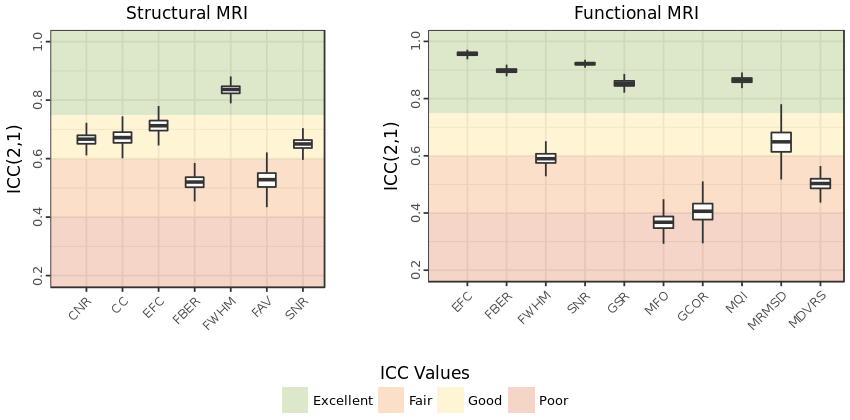

In [92]:
options(repr.plot.width=180.0/25.4, repr.plot.height=3.5)
# extract the legend
lay <- rbind(c(1,1,1,1,1,1,1,NA,2,2,2,2,2,2,2,2,2,2),
             c(3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3))

g <- ggplotGrob(p[[1]] + theme(legend.position="bottom"))$grobs
legend <- g[[which(sapply(g, function(x) x$name) == "guide-box")]]
lheight <- sum(legend$height)

grid.arrange(
    p[[1]] + theme(legend.position="none"),
    p[[2]] + theme(legend.position="none"),
    legend,
    layout_matrix=lay,
    heights=unit(c(3.0,0.5), c("in","in")))

In [93]:
pdf("icc_plot.pdf", width = 180.0/25.4, height = 3.5, family="ArialMT")
grid.arrange(
    p[[1]] + theme(legend.position="none"),
    p[[2]] + theme(legend.position="none"),
    legend,
    layout_matrix=lay,
    heights=unit(c(3.0,0.5), c("in","in")))
dev.off()

png 
  2